# 2024 CVE Time Series Forecasting using Kalman Filter

Backgound on the Kalman Filter:
https://en.wikipedia.org/wiki/Kalman_filter 

Python Library Used: 
https://unit8co.github.io/darts/

In [1]:
%%capture
!pip3 install darts
!mkdir -p jsondata
%cd jsondata
!rm *.json 
!rm *.zip 
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2000..2024}.json.zip 
!unzip -o "*.zip" 

In [2]:
from IPython.core.magic import register_cell_magic
from IPython.display import Markdown
from datetime import date
import datetime
import glob
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly
import re
import sys
import uuid
import warnings
import pandas as pd
from darts import TimeSeries
from darts.models import KalmanForecaster
import matplotlib.pyplot as plt

@register_cell_magic
def markdown(line, cell):
    return Markdown(cell.format(**globals()))


logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore")
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)

In [3]:

row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                assigner = entry['cve']['CVE_data_meta']['ASSIGNER']
            except KeyError:
                assigner = 'Missing_Data'
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = '0.0'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description,
                'Assigner' : assigner
            }
            if not description.startswith('Rejected reason'): 
                row_accumulator.append(new_row)
        nvd = pd.DataFrame(row_accumulator)
    
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd = nvd.sort_values(by=['Published'])
nvd = nvd.reset_index(drop=True)
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = pd.to_numeric(nvd['BaseScore']);
nvd['BaseScore'] = nvd['BaseScore'].replace(0, np.NaN);
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
pastdata = ((nvd['Published'] > '2017-01-01') & (nvd['Published']  < '2024-01-01'))
thisyear = ((nvd['Published'] > '2024-01-01') & (nvd['Published']  < '2025-01-01'))
nvd_2024 = nvd.loc[thisyear]
nvd = nvd.loc[pastdata]
startdate = date(2017, 1, 1)
enddate  = date(2024, 1, 1)
numberofdays = enddate - startdate 
per_day = nvdcount/numberofdays.days

In [4]:
Markdown(f"Total Number of CVEs: **{nvd['CVE'].count()}**<br />Average CVEs Per Day: **{per_day.round(2)}**<br />Average CVSS Score: **{nvd['BaseScore'].mean().round(2)}**")

Total Number of CVEs: **140848**<br />Average CVEs Per Day: **86.5**<br />Average CVSS Score: **7.19**

In [5]:
nvd['Published'] = pd.to_datetime(nvd['Published'])
monthly = nvd['Published'].groupby(nvd.Published.dt.to_period("M")).agg('count')
monthly_cves = pd.DataFrame(monthly)
monthly_cves.columns = ['Count']
monthly_cves = monthly_cves .reset_index()
monthly_cves = monthly_cves.rename(columns={"Published" : "Month" ,"Count": "CVEs"})
monthly_cves['Month'] = monthly_cves['Month'].astype(str)
monthly_cves['Month'] = pd.to_datetime(monthly_cves['Month'])
monthly_cves.dtypes
monthly_cves 

,Month,CVEs
0,2017-01-01,1083
1,2017-02-01,1041
2,2017-03-01,1300
3,2017-04-01,1570
4,2017-05-01,1010
...,...,...
79,2023-08-01,2478
80,2023-09-01,2149
81,2023-10-01,2680
82,2023-11-01,2452


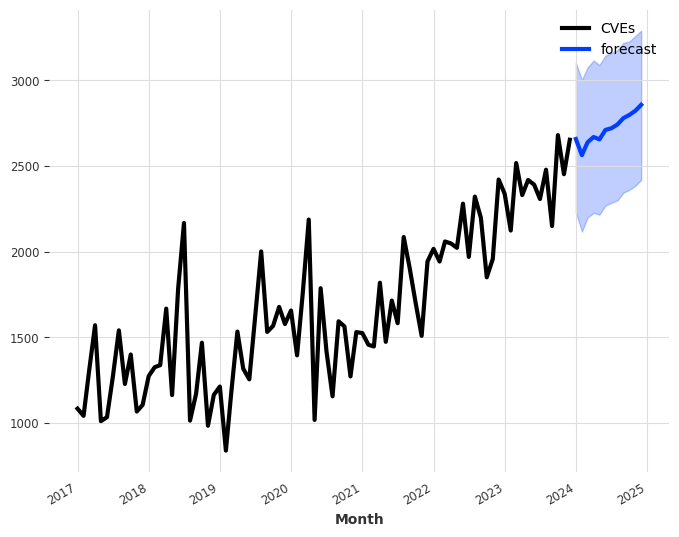

In [6]:
train = TimeSeries.from_dataframe(monthly_cves,"Month", "CVEs")
model = KalmanForecaster(dim_x=4)
model.fit(train)
pred = model.predict(n=12, num_samples=10000)

plt.figure(figsize=(8,6))
train.plot(lw=3)
pred.plot(lw=3, label='forecast')

In [7]:
darts_df = pred.pd_dataframe();

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


In [17]:
darts_monthly = pred.pd_dataframe().mean(axis = 1).round(0)
darts_monthly = darts_monthly.to_frame()
darts_monthly = darts_monthly.reset_index()
darts_monthly = darts_monthly.rename(columns={0 : "CVEs Predicted"})
darts_monthly['Month'] = darts_monthly['Month'].dt.month_name()
darts_monthly

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


,Month,CVEs Predicted
0,January,2661.0
1,February,2562.0
2,March,2637.0
3,April,2666.0
4,May,2652.0
5,June,2709.0
6,July,2721.0
7,August,2741.0
8,September,2779.0
9,October,2795.0


In [9]:
darts_monthly.sum()

Month             JanuaryFebruaryMarchAprilMayJuneJulyAugustSept...
CVEs Predicted                                              32600.0
dtype: object

In [10]:
monthly_2024 = nvd_2024['Published'].groupby(nvd_2024.Published.dt.to_period("M")).agg('count')
monthly_cves_2024 = pd.DataFrame(monthly_2024)
monthly_cves_2024.columns = ['Count']
monthly_cves_2024 = monthly_cves_2024.reset_index()
monthly_cves_2024 = monthly_cves_2024.rename(columns={"Published" : "Month" ,"Count": "CVEs Actual"})
monthly_cves_2024['Month'] = monthly_cves_2024['Month'].astype(str)
monthly_cves_2024['Month'] = pd.to_datetime(monthly_cves_2024['Month'])
monthly_cves_2024['Month'] = monthly_cves_2024['Month'].dt.month_name()
monthly_cves_2024

,Month,CVEs Actual
0,January,281


In [11]:
validation_df = pd.merge(
    monthly_cves_2024,
    darts_monthly,
    how="outer",
    on='Month',
)

validation_df = validation_df.iloc[:12]
validation_df = validation_df[['Month', 'CVEs Predicted', 'CVEs Actual']]
validation_df['Difference'] = validation_df['CVEs Actual'] -  validation_df['CVEs Predicted'] 
validation_df = validation_df.append(validation_df.sum(numeric_only=True), ignore_index=True)

In [12]:

def percentage_change(col1,col2):
    return ((col2 / col1) * 100).round(0)


validation_df.at[12,'Month']='Total'
validation_df.fillna(0) 
validation_df['Precentage'] = percentage_change(validation_df['CVEs Predicted'],validation_df['CVEs Actual'])   
validation_df

,Month,CVEs Predicted,CVEs Actual,Difference,Precentage
0,January,2661.0,281.0,-2380.0,11.0
1,February,2562.0,NaN,NaN,NaN
2,March,2637.0,NaN,NaN,NaN
3,April,2666.0,NaN,NaN,NaN
4,May,2652.0,NaN,NaN,NaN
5,June,2709.0,NaN,NaN,NaN
6,July,2721.0,NaN,NaN,NaN
7,August,2741.0,NaN,NaN,NaN
8,September,2779.0,NaN,NaN,NaN
9,October,2795.0,NaN,NaN,NaN


In [13]:
darts_total = darts_monthly.copy()
darts_total.at[12,'Month']='Total'
darts_total.fillna(0) 
darts_total.append(darts_total.sum(numeric_only=True), ignore_index=True)
darts_total

,Month,CVEs Predicted
0,January,2661.0
1,February,2562.0
2,March,2637.0
3,April,2666.0
4,May,2652.0
5,June,2709.0
6,July,2721.0
7,August,2741.0
8,September,2779.0
9,October,2795.0


In [14]:
validation_df

,Month,CVEs Predicted,CVEs Actual,Difference,Precentage
0,January,2661.0,281.0,-2380.0,11.0
1,February,2562.0,NaN,NaN,NaN
2,March,2637.0,NaN,NaN,NaN
3,April,2666.0,NaN,NaN,NaN
4,May,2652.0,NaN,NaN,NaN
5,June,2709.0,NaN,NaN,NaN
6,July,2721.0,NaN,NaN,NaN
7,August,2741.0,NaN,NaN,NaN
8,September,2779.0,NaN,NaN,NaN
9,October,2795.0,NaN,NaN,NaN
